In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

import networkx as nx

import argparse
import torch
import torch.nn as nn
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from torch.nn.parameter import Parameter
import torch.nn as nn
import math

from torch.autograd import grad
import pandas as pd
import seaborn as sns

from scipy.interpolate import griddata
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.decomposition import PCA

import itertools
from tqdm.auto import tqdm  # This is the recommended way

In [ ]:
def burgers_equation(nx = 1000, nt=500, tmax=1.5, ub = 1.0, lb = -1.0, nu=0.1):
    """
    Solve the Burger's equation: du/dt + u*du/dx = nu*d^2u/dx^2
    using implicit finite difference method

    Parameters:
        nx: number of spatial points
        nt: number of time steps
        tmax: maximum time
        ub: upper bound of the spatial domain
        lb: lower bound of the spatial domain
        nu: viscosity coefficient
    """
    # Set up grid
    L = ub - lb
    dx = L/nx
    dt = tmax/nt
    x = np.linspace(lb, ub, nx)
    t = np.linspace(0, tmax, nt)

    # Initialize solution array
    u = np.zeros((nt, nx))

    # Initial condition (sinusoidal wave)
    u[0, :] = -np.sin(np.pi*x)

    # Create sparse matrices for implicit scheme
    r = nu*dt/(dx**2)

    for n in range(0, nt-1):
        # Create coefficient matrix A_tilde
        main_diag = 1 + 2*r * np.ones(nx)
        upper_diag = -r * np.ones(nx-1)
        lower_diag = -r * np.ones(nx-1)

        A_tilde = diags([main_diag, upper_diag, lower_diag], [0, 1, -1], format='csr')

        # Create RHS vector
        b = u[n, :] - dt/(2*dx) * u[n, :] * (np.roll(u[n, :], -1) - np.roll(u[n, :], 1))

        # Apply periodic boundary conditions
        b[0] = u[n, 0]
        b[-1] = u[n, -1]

        # Solve system
        u[n+1, :] = spsolve(A_tilde, b)

    return x, t, u

def plot_solution(x, t, u):
    """Plot the solution as a 2D heatmap and final time snapshot"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    # Plot heatmap
    im = ax1.pcolormesh(x, t, u, shading='auto')
    ax1.set_xlabel('x')
    ax1.set_ylabel('t')
    ax1.set_title("Burger's equation solution")
    plt.colorbar(im, ax=ax1)

    # Plot final time solution
    ax2.plot(x, u[-1, :], 'b-', label='Final time')
    ax2.plot(x, u[0, :], 'r--', label='Initial condition')
    ax2.set_xlabel('x')
    ax2.set_ylabel('u')
    ax2.legend()
    ax2.set_title('Solution at final time')

    plt.tight_layout()
    plt.show()

# Generate and plot solution
x, time, u = burgers_equation()

In [ ]:
np.random.seed(42)

u_rand = u + np.random.normal(0, 0.1, u.shape)
#u_rand = u

In [ ]:
n_nodes = 30

np.random.seed(42)

x_node = np.random.choice(x, n_nodes, replace=False)

x_node_indeces = np.where(np.isin(x,x_node))[0]

velocity = u_rand[:,x_node_indeces]

In [ ]:
def adjacency_matrix(data, x_node, window_size=5, alpha=0.5, threshold = 0.4):
    """
    Enhanced adjacency matrix construction incorporating both spatial and temporal correlations

    Args:
        data: velocity data of shape [t, n_nodes]
        x_node: spatial coordinates of nodes
        window_size: window for temporal correlation
        alpha: weight between spatial and temporal correlation
        spatial_threshold: threshold for spatial connections
        temporal_threshold: threshold for temporal connections
    """
    n_nodes = len(x_node)

    Ws = np.exp(-(x_node[:,np.newaxis] - x_node)**2/np.std(x_node)) - np.eye(len(x_node))

    # Combine spatial and temporal correlations
    A = Ws

    threshold = 0.65

    A_temp = A.copy()
    A_temp[A<=threshold] = 0

    G = nx.Graph(A_temp)

    # while not nx.is_connected(G) and threshold>=0:

    #     threshold -= 0.01
    #     A_temp = A.copy()
    #     A_temp[A<=threshold] = 0
    #     G = nx.Graph(A_temp)

    return A_temp, threshold

In [ ]:
A,threshold = adjacency_matrix(velocity, x_node)

In [ ]:
def block_mask_test(set_size, n_nodes, possible_nodes):

    mask = torch.ones((set_size, n_nodes), dtype = torch.int)
    max_length_masked = set_size/2

    node_seen = []

    #for node in possible_nodes:
    for node in range(n_nodes):

      if np.random.binomial(1,0.3) == 1:

        random_length = np.random.randint(0, max_length_masked)
        init_val = np.random.randint(0, set_size)
        node_seen.append(node)
        mask[init_val:init_val+random_length, node] = 0

    return mask


In [ ]:
def block_mask(train_size, val_size, test_size, n_nodes):

  mask_train = torch.ones((train_size, n_nodes), dtype = torch.int)

  max_length_masked_train = train_size/4

  node_seen_train = []
  for node in range(n_nodes):

    if np.random.binomial(1,0.5) == 1: # Chose the node as node masked
      random_length = np.random.randint(0, max_length_masked_train) # Chose the time frame of node's non availability
      init_val = np.random.randint(0,train_size) # Chose the time step from when the node start to be non avilable
      node_seen_train.append(node)
      mask_train[init_val:init_val+random_length, node] = 0 # Set to zero the period of node's non availability

  #masked_nodes_train = [np.where(mask_train[t,:] == 0)[0] for t in range(train_size)] # list of node masked at each time step in training set

  total_masked = np.unique(node_seen_train) # list of unique node masked

  possible_choice_masked_nodes = np.where(~np.isin(np.arange(n_nodes), total_masked))[0] # chose nodes to mask in test set that has never been mask

  sep = int(len(possible_choice_masked_nodes)/2)
  possible_nodes_val = possible_choice_masked_nodes[:sep]
  possible_nodes_test = possible_choice_masked_nodes[sep:]

  mask_val = block_mask_test(val_size, n_nodes, possible_nodes_val)

  mask_test = block_mask_test(test_size, n_nodes, possible_nodes_test)

  return mask_train, mask_val, mask_test #, masked_nodes_train, masked_nodes_test

In [ ]:
def get_A_hat(adj):
  A_tilde = torch.tensor(adj, dtype = torch.float32) + torch.eye(adj.shape[0], dtype = torch.float32)

  # computing D_tilde, D_tilde_inv and D_tilde_inv**(1/2)
  A_bin = A_tilde.clone()
  A_bin[A_bin!=0] = 1
  D_tilde = np.array(torch.diag(torch.sum(A_bin, axis = 1)))
  D_tilde_inv = np.linalg.inv(D_tilde)
  D_tilde_inv_sqrt = np.sqrt(D_tilde_inv)
  D_tilde_inv_sqrt[~np.isfinite(D_tilde_inv_sqrt)] = 0
  D_tilde_inv_sqrt = torch.tensor(D_tilde_inv_sqrt, dtype = torch.float32)

  # final adjacency matrix
  A_hat = D_tilde_inv_sqrt@A_tilde@D_tilde_inv_sqrt

  return A_hat



In [ ]:
def create_data(data, A, mask, set_size):

  mask = mask.clone()

  mask = [torch.tensor(mask[tt,:], dtype = torch.float32) for tt in range(set_size)]
  masked_nodes = [np.where(mask[tt]==0)[0] for tt in range(set_size)]
  unmasked_nodes = [np.where(~np.isin(np.arange(len(x_node)), mm))[0] for mm in masked_nodes]

  # #obscured_node_index = [np.where(np.array(mask[i])==-float("Inf"))[0] for i in range(len(t))]

  A_list = []
  X_list = []
  mask_list = []

  V_temp = data.clone()
  A_temp = A.clone()

  #inductive nodes, I remove masked nodes. Note that the weight matrix in message passing does not depend on the number of nodes, so I can learn it on a graph with N nodes and test it on a graph with N2 nodes

  for i in range(set_size):

        m = mask[i]

        A_temp = A*m*m.unsqueeze(1) # set the corresponding row and column of masked index to zero in order to detach the node with missing values from the graph
        A_temp[masked_nodes[i],masked_nodes[i]] = A[masked_nodes[i],masked_nodes[i]] # allow self loop even to nodes with missing values

        A_hat = get_A_hat(A_temp)

        V_temp[i,masked_nodes[i]]= torch.mean(data[i,:])


        mask[i][masked_nodes[i]] = -float("Inf")  # nodes with missing velocities set to -Inf

        A_list.append(A_hat)
        mask_list.append(mask[i])


  A_list = [a.float() for a in A_list]
  V_temp = V_temp.float()
  mask_list = [m.float() for m in mask_list]
  masked_nodes = [torch.tensor(mm, dtype = torch.long) for mm in masked_nodes]
  unmasked_nodes = [torch.tensor(mm, dtype = torch.long) for mm in unmasked_nodes]

  return (A_list, V_temp, mask_list, masked_nodes, unmasked_nodes)

In [ ]:
def train_test_split(data, A, train_size, val_size, test_size, n_nodes):

  #vel = data_tot[:,:,-1].reshape(500,30)

  mask_train, mask_val, mask_test = block_mask(train_size, val_size, test_size, n_nodes)

  vel_train = data.clone()
  vel_train = vel_train[:train_size, :]
  train = create_data(vel_train, torch.tensor(A), mask_train, train_size)

  vel_val = data.clone()
  vel_val = vel_val[train_size:train_size+val_size, :]
  val = create_data(vel_val, torch.tensor(A), mask_val, val_size)

  vel_test = data.clone()
  vel_test = vel_test[-test_size:, :]
  test = create_data(vel_test, torch.tensor(A), mask_test, test_size)

  vel_train_val = data.clone()
  vel_train_val = vel_train_val[:train_size+val_size, :]
  mask_train_val = torch.cat((mask_train, mask_val), dim = 0)
  train_val = create_data(vel_train_val, torch.tensor(A), mask_train_val, train_size+val_size)

  return train, val, test, train_val



In [ ]:
np.random.seed(42)

# combination position and time
T,X = np.meshgrid(time, x_node)

data_vel = torch.tensor(velocity, dtype = torch.float32)

train_size = 400
val_size = 50
test_size = 50

out_data_train, out_data_val, out_data_test, out_data_train_val = train_test_split(data_vel, torch.tensor(A), train_size, val_size, test_size, n_nodes)



<ipython-input-10-844463d39344>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train = create_data(vel_train, torch.tensor(A), mask_train, train_size)
<ipython-input-9-77e59aa86554>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = [torch.tensor(mask[tt,:], dtype = torch.float32) for tt in range(set_size)]
<ipython-input-8-b9855a1932ce>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_tilde = torch.tensor(adj, dtype = torch.float32) + torch.eye(adj.shape[0], dtype = torch.float32)
<ipython-input-10-844463d39344>:13: UserWarning:

Controllo sei grafi ad ogni tempo sono connessi

In [ ]:
for i,A_hat in enumerate(out_data_train[0]):
    G = nx.from_numpy_array(A_hat.numpy())
    nodes_to_remove = out_data_train[3][i].tolist()  # Convert to list if necessary
    # Ensure nodes_to_remove exist in G
    nodes_to_remove = [node for node in nodes_to_remove if node in G.nodes]
    G.remove_nodes_from(nodes_to_remove)

    if not nx.is_connected(G):
        print(f"The graph {i} is not connected.")

In [ ]:
out_data_train[3][20]

tensor([15])

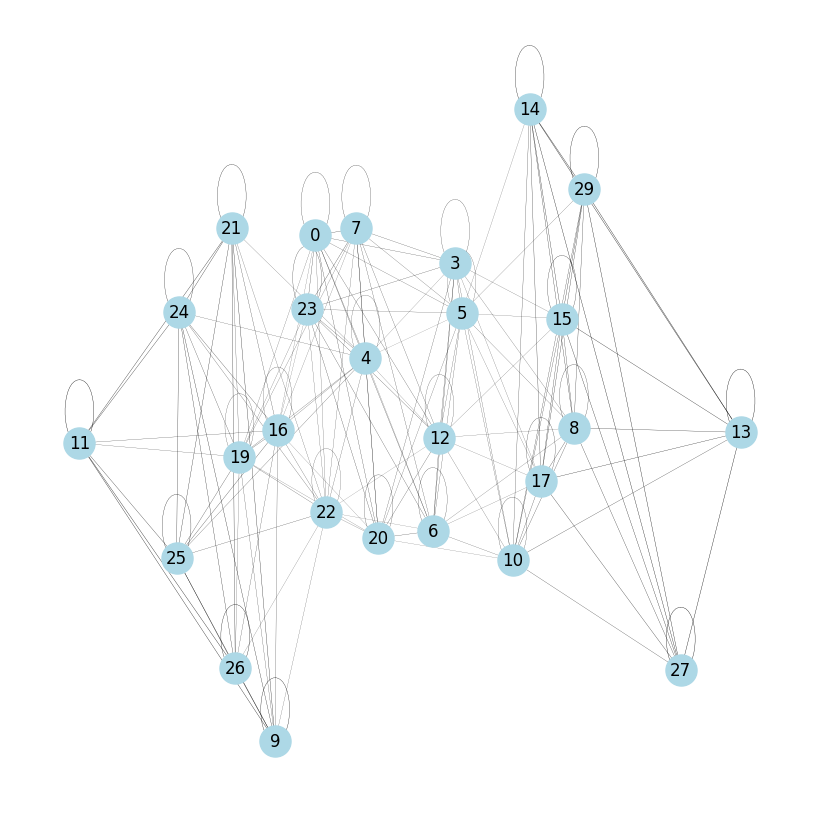

In [ ]:
G = nx.from_numpy_array(out_data_train[0][241].numpy())

nodes_to_remove = out_data_train[3][241].tolist()  # Convert to list if necessary

# Ensure nodes_to_remove exist in G
nodes_to_remove = [node for node in nodes_to_remove if node in G.nodes]

G.remove_nodes_from(nodes_to_remove)

# Generate node positions
pos = nx.kamada_kawai_layout(G)

# Rotate the graph by 90 degrees by swapping x and y coordinates
rotated_pos = {node: (y, -x) for node, (x, y) in pos.items()}  # Swap and negate y for 90-degree rotation

# Edge widths proportional to weights
weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]  # Multiply by 2 to make more visible

# Plot the rotated graph
plt.figure(figsize=(8, 8))
nx.draw(G, rotated_pos, width=weights, with_labels=True,
        node_color='lightblue', node_size=500)
plt.show()

In [ ]:
def pad_with_last_val(vect, k):
    device = vect.device  # Get device directly from tensor
    pad = torch.ones(k - vect.size(0),
                    dtype=torch.long,
                    device=device) * vect[-1]
    vect = torch.cat([vect, pad])
    return vect

# Fix the pad_with_zeros function similarly
def pad_with_zeros(vect, n):
    device = vect.device  # Get device directly from tensor
    pad = torch.zeros(n - vect.size(0),
                     dtype=torch.long,
                     device=device)
    vect = torch.cat([vect, pad])
    return vect

class Namespace(object):
    '''
    helps referencing object in a dictionary as dict.key instead of dict['key']
    '''
    def __init__(self, adict):
        self.__dict__.update(adict)


class EGCN(torch.nn.Module):
    def __init__(self, args, activation, device='cpu', skipfeats=False):
        super().__init__()
        GRCU_args = Namespace({})

        feats = [args.feats_per_node,
                 args.layer_1_feats,
                #  args.layer_2_feats,
                #  args.layer_3_feats,
                 ]
        self.device = device
        self.skipfeats = skipfeats

        self.GRCU_layers = nn.ModuleList()
        for i in range(1, len(feats)):
            GRCU_args = Namespace({'in_feats': feats[i - 1],
                                   'out_feats': feats[i],
                                   'activation': activation})

            grcu_i = GRCU(GRCU_args)
            self.GRCU_layers.append(grcu_i.to(self.device))

    def forward(self, A_list, Nodes_list, nodes_mask_list):
        node_feats = Nodes_list[-1]

        for unit in self.GRCU_layers:
            Nodes_list, weights = unit(A_list, Nodes_list, nodes_mask_list)

        if self.skipfeats:
            out = torch.cat((Nodes_list[-1], node_feats), dim=1)  # Use `node_feats.to_dense()` if 2-hot encoded input
        return Nodes_list, weights

class GRCU(torch.nn.Module):
    def __init__(self,args):
        super().__init__()
        self.args = args
        cell_args = Namespace({})
        cell_args.rows = args.in_feats
        cell_args.cols = args.out_feats

        self.evolve_weights = mat_GRU_cell(cell_args)

        self.activation = self.args.activation
        self.GCN_init_weights = Parameter(torch.Tensor(self.args.in_feats,self.args.out_feats))
        self.reset_param(self.GCN_init_weights)

        self.register_buffer("last_train_weights", None)
        self.is_training = True


    def reset_param(self,t):
        #Initialize based on the number of columns
        stdv = 1. / math.sqrt(t.size(1))
        t.data.uniform_(-stdv,stdv)

    def train(self, mode=True):  # when I call model.train() during training this set the is_training to True, then when I call model.eval() this set the is_training to false
        super().train(mode)
        self.is_training = mode
        return self

    def save_last_weights(self, weights):
        if weights is not None:
            self.last_train_weights = torch.tensor(weights, device = self.GCN_init_weights.device)

    def forward(self,A_list,node_embs_list,mask_list):

        if not self.is_training and self.last_train_weights is not None: # if inference, the weights are initialized using the weights of last embedding during training
            GCN_weights = self.last_train_weights

        else:
            GCN_weights = self.GCN_init_weights

        out_seq = []
        weights = []
        for t,Ahat in enumerate(A_list):
            node_embs = node_embs_list[t]
            #first evolve the weights from the initial and use the new weights with the node_embs

            GCN_weights = self.evolve_weights(GCN_weights,node_embs,mask_list[t])

            weights.append(GCN_weights.detach().cpu().numpy())

            node_embs = self.activation(Ahat.matmul(node_embs.matmul(GCN_weights)))

            out_seq.append(node_embs)

            if self.is_training and t == len(A_list) - 1: # save the weights of last embedding
                self.save_last_weights(GCN_weights.detach())

        return out_seq, weights

class mat_GRU_cell(torch.nn.Module):
    def __init__(self,args):
        super().__init__()
        self.args = args
        self.update = mat_GRU_gate(args.rows,
                                   args.cols,
                                   torch.nn.Sigmoid())

        self.reset = mat_GRU_gate(args.rows,
                                   args.cols,
                                   torch.nn.Sigmoid())

        self.htilda = mat_GRU_gate(args.rows,
                                   args.cols,
                                   torch.nn.ReLU())

        self.choose_topk = TopK(feats = args.rows,
                                k = args.cols )

    def forward(self,prev_Q,prev_Z,mask):
        z_topk = self.choose_topk(prev_Z,mask)

        update = self.update(z_topk,prev_Q)
        reset = self.reset(z_topk,prev_Q)

        h_cap = reset * prev_Q
        h_cap = self.htilda(z_topk, h_cap)

        new_Q = (1 - update) * prev_Q + update * h_cap

        return new_Q



class mat_GRU_gate(torch.nn.Module):
    def __init__(self,rows,cols,activation):
        super().__init__()
        self.activation = activation
        #the k here should be in_feats which is actually the rows
        self.W = Parameter(torch.Tensor(rows,rows))
        self.reset_param(self.W)

        self.U = Parameter(torch.Tensor(rows,rows))
        self.reset_param(self.U)

        self.bias = Parameter(torch.zeros(rows,cols))

    def reset_param(self,par):
        #Initialize based on the number of columns
        stdv = 1. / math.sqrt(par.size(1))
        par.data.uniform_(-stdv,stdv)

    def forward(self,x,hidden):
        out = self.activation(self.W.matmul(x) + \
                              self.U.matmul(hidden) + \
                              self.bias)

        return out

class TopK(torch.nn.Module):
    def __init__(self,feats,k):
        super().__init__()
        self.scorer = Parameter(torch.Tensor(feats,1))
        self.reset_param(self.scorer)

        self.k = k

    def reset_param(self,par):
        #Initialize based on the number of rows
        stdv = 1. / math.sqrt(par.size(0))
        par.data.uniform_(-stdv,stdv)


    def forward(self, node_embs, mask):
        # # Compute scores

        scores = node_embs.matmul(self.scorer) / self.scorer.norm()
        scores = scores + mask.view(-1, 1)
        num_nodes = node_embs.size(0)

        if self.k <= num_nodes:
            vals, topk_indices = scores.view(-1).topk(self.k)
            topk_indices = topk_indices[vals > -float("Inf")]

            if topk_indices.size(0) < self.k:
                topk_indices = pad_with_last_val(topk_indices, self.k)

            selected_nodes = node_embs[topk_indices]
            selected_scores = scores[topk_indices]

        else:
            vals, topk_indices = scores.view(-1).topk(num_nodes)
            valid_mask = vals > -float("Inf")
            topk_indices = topk_indices[valid_mask]

            if topk_indices.size(0) < self.k:
                topk_indices = pad_with_last_val(topk_indices, self.k)

            selected_nodes = node_embs[topk_indices]
            selected_scores = scores[topk_indices]
            remaining_k = self.k - topk_indices.size(0)

            if remaining_k > 0:
                vals, sorted_indices = scores.view(-1).sort(descending=True)
                valid_mask = vals > -float("Inf")
                sorted_indices = sorted_indices[valid_mask]

                if remaining_k <= num_nodes:
                    repeat_indices = sorted_indices[:remaining_k]
                else:
                    repeat_times = (remaining_k + num_nodes - 1) // num_nodes
                    repeat_indices = sorted_indices.repeat(repeat_times)[:remaining_k]

                if repeat_indices.size(0) < remaining_k:
                    repeat_indices = pad_with_last_val(repeat_indices, remaining_k)

                repeated_nodes = node_embs[repeat_indices]
                repeated_scores = scores[repeat_indices]

                selected_nodes = torch.cat([selected_nodes, repeated_nodes], dim=0)
                selected_scores = torch.cat([selected_scores, repeated_scores], dim=0)

        tanh = torch.nn.Tanh()
        out = selected_nodes * tanh(selected_scores.view(-1, 1))
        return out.t()


# with one MLP
class PredictionEGCN(nn.Module):
    def __init__(self, args, activation, n_nodes, device, p_dropout, k, time_size):
        super().__init__()

        # hidden_layers = domain_search["hidden_layers"]
        # p_dropout = domain_search["p_dropout"]

        self.k = k
        self.args = args
        self.device = device
        self.n_nodes = n_nodes
        self.embedding = EGCN(args, activation, device)

        # Increased network capacity with attention and skip connections
        hidden_dim = (self.args.layer_1_feats+1) * self.n_nodes

        self.node_specific_nn = nn.Sequential(nn.Linear(hidden_dim, 128, bias = False),
                                                              nn.LeakyReLU(),
                                                              nn.Dropout(p_dropout),
                                                              nn.Linear(128, 64, bias = False),
                                                              nn.LeakyReLU(),
                                                              nn.Dropout(p_dropout),
                                                              nn.Linear(64,30, bias = False))



    def forward(self, A_list, g, vel, nodes_mask_list):

        dummy_mask = torch.stack(nodes_mask_list)
        dummy_mask[dummy_mask==-float("Inf")] = 0
        time_size = len(A_list)
        gg = torch.cat((g.reshape(time_size,30,2), vel.reshape(-1,1).reshape(time_size,30,1), dummy_mask.reshape(-1,1).reshape(time_size,30,1)), dim = 2)
        Nodes_list = [g for g in gg]
        final_embed, self.weights = self.embedding(A_list, Nodes_list, nodes_mask_list)
        prediction_for_each_t = []


        # Process each timestep
        for i in range(len(final_embed)):
            embed_mat = final_embed[i]
            embed_mat = torch.cat((Nodes_list[i][:,0].reshape(-1,1), embed_mat), dim = 1)
            embed = embed_mat.flatten().unsqueeze(0)
            pred = self.node_specific_nn(embed).reshape(-1)
            prediction_for_each_t.append(pred)

        return prediction_for_each_t, weights


# with many MLP, one for each time step
class PredictionEGCN2(nn.Module):
    def __init__(self, args, activation, n_nodes, device, p_dropout, k, time_size):
        super().__init__()

        # hidden_layers = domain_search["hidden_layers"]
        # p_dropout = domain_search["p_dropout"]

        self.k = k
        self.args = args
        self.device = device
        self.n_nodes = n_nodes
        self.embedding = EGCN(args, activation, device)

        # Increased network capacity with attention and skip connections
        hidden_dim = (self.args.layer_1_feats) * self.n_nodes


        self.node_specific_nn = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, 128, bias = False),
                                                              nn.LeakyReLU(),
                                                              nn.Dropout(p_dropout),
                                                              nn.Linear(128, 64, bias = False),
                                                              nn.LeakyReLU(),
                                                              nn.Dropout(p_dropout),
                                                              nn.Linear(64,30, bias = False)) for _ in range(time_size)])


        for i in range(time_size):
            self.register_buffer(f'last_weights_layer1_{i}', None)
            self.register_buffer(f'last_weights_layer2_{i}', None)
            self.register_buffer(f'last_weights_layer3_{i}', None)

    def train(self, mode=True):
        super().train(mode)
        self.is_training = mode
        if not mode:  # If switching to eval mode, the weights are initialized taking the weights of last MLP
            self.initialize_eval_weights()
        return self

    def save_training_weights(self):
        """Save the current weights of all networks"""
        if self.is_training:
            for i, network in enumerate(self.node_specific_nn):
                # Save weights for each layer
                self.register_buffer(f'last_weights_layer1_{i}',
                                  network[0].weight.detach().clone())  # First Linear layer
                self.register_buffer(f'last_weights_layer2_{i}',
                                  network[3].weight.detach().clone())  # Second Linear layer
                self.register_buffer(f'last_weights_layer3_{i}',
                                  network[6].weight.detach().clone())  # Third Linear layer

    def initialize_eval_weights(self):
        """Initialize weights for evaluation using saved weights"""
        for i, network in enumerate(self.node_specific_nn):
            # Check if we have saved weights
            if getattr(self, f'last_weights_layer1_{i}') is not None:
                with torch.no_grad():
                    network[0].weight.copy_(getattr(self, f'last_weights_layer1_{i}'))
                    network[3].weight.copy_(getattr(self, f'last_weights_layer2_{i}'))
                    network[6].weight.copy_(getattr(self, f'last_weights_layer3_{i}'))



    def forward(self, A_list, g, vel, nodes_mask_list):

        dummy_mask = torch.stack(nodes_mask_list)
        dummy_mask[dummy_mask==-float("Inf")] = 0
        time_size = len(A_list)
        gg = torch.cat((g.reshape(time_size, 30, 2), vel.reshape(-1,1).reshape(time_size,30,1), dummy_mask.reshape(-1,1).reshape(time_size,30,1)), dim = 2)
        Nodes_list = [g for g in gg]
        final_embed, self.weights = self.embedding(A_list, Nodes_list, nodes_mask_list)
        prediction_for_each_t = []


        # Process each timestep
        for i in range(len(final_embed)):
            embed_mat = final_embed[i]
            embed = embed_mat.flatten().unsqueeze(0)
            pred = self.node_specific_nn[i](embed).reshape(-1)
            prediction_for_each_t.append(pred)

        if self.is_training: # Save the weights of last MLP
           self.save_training_weights()

        return prediction_for_each_t, weights

In [ ]:
torch.tensor([1,2,3]).reshape(-1,1)

tensor([[1],
        [2],
        [3]])

# One MLP

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

args_dict = Namespace({
        'feats_per_node': 4,
        'layer_1_feats': 16, # 16 is good
        # 'layer_2_feats': 16,
        # 'layer_3_feats': 8,
        }) # output dim

activation = nn.ReLU()

A_list_train_val = [a.to(device) for a in out_data_train_val[0]]
mask_list_train_val = [m.to(device) for m in out_data_train_val[2]]
velocity_train_val = data_vel[:train_size+val_size,:].to(device)
missing_nodes_train_val = [mn.to(device) for mn in out_data_train_val[3]]

tt_train_val = torch.tensor(time[:train_size+val_size], dtype = torch.float32).to(device)
xx = torch.tensor(x_node, dtype = torch.float32).to(device)
g_train_val = torch.stack(torch.meshgrid(tt_train_val, xx)).reshape(2,-1).T.requires_grad_(True).to(device)
vel_train_val = out_data_train_val[1].to(device)

#data_tot = data_tot.to(device)

n_nodes = len(x_node)

model = PredictionEGCN(args_dict, activation, n_nodes, device, 0.5, 3, time_size = train_size+val_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
model.train()


prev_epoch_loss = torch.tensor(float("Inf"))
counter = 0

n_epochs = 30

lambda_physics = 0.3

train_data_loss = []
train_loss = []
test_loss = []
train_loss_physics = []

nu = 0.1

data_loss_list = []


for epoch in range(n_epochs):
    epoch_loss = 0
    predictions_t = []

    optimizer.zero_grad()

    #predictions, weights = model.forward(A_list_train_val, g_train_val, vel_train_val, mask_list_train_val)
    predictions, weights = model.forward(A_list_train_val, g_train_val, vel_train_val, mask_list_train_val)

    uu = torch.stack(predictions).reshape(-1)


    du_dg = torch.autograd.grad(
          inputs=g_train_val,
          outputs=uu,
          grad_outputs=torch.ones_like(uu),
          retain_graph=True,
          create_graph=True
      )[0]

    du_dt = du_dg[:,0]
    du_dx = du_dg[:,1]

    du_dxx = torch.autograd.grad(
          inputs=g_train_val,
          outputs=du_dg,
          grad_outputs=torch.ones_like(du_dg),
          retain_graph=True,
          create_graph=True
      )[0][:, 0]



    f = uu*du_dx + du_dt - nu*du_dxx

    physics_loss = F.mse_loss(f,torch.zeros_like(f))

    train_loss_physics.append(physics_loss.detach().item())


    data_loss = 0
    missing_train = 0
    count_missing = 0
    count_available = 0
    available_train = 0
    imputation_loss = 0
    data_init_loss = 0


    for i in range(train_size+val_size):

      mask = mask_list_train_val[i].clone()
      mask[mask==-float("Inf")]=0

      data_loss += F.mse_loss(predictions[i],velocity_train_val[i,:])

      if len(torch.where(mask == 1)[0]) != 0:
        available_train += F.mse_loss(predictions[i][mask==1],velocity_train_val[i,mask==1])
        count_available += 1

      if len(torch.where(mask == 0)[0]) != 0:
        missing_train += F.mse_loss(predictions[i][mask==0],velocity_train_val[i,mask==0])
        count_missing += 1

      if epoch == n_epochs-1:
        data_loss_list.append(data_loss)

    data_mean_loss = data_loss/len(time)
    missing_train = missing_train/count_missing
    available_train = available_train/count_available

    total_loss = data_mean_loss * (1-lambda_physics) + physics_loss*lambda_physics

    train_data_loss.append(data_mean_loss.detach().item())
    train_loss.append(total_loss.detach().item())

    total_loss.backward()
    optimizer.step()

    if epoch % 2 == 0:
        print(f"Epoch {epoch}")
        print(f"Data Loss: {data_mean_loss:.6f}")
        print(f"Physics Loss: {physics_loss:.6f}")
        print(f"missing train: {missing_train:.6f}")
        print(f"available train: {available_train:.6f}")


<ipython-input-179-c378bf2dfe3f>:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.last_train_weights = torch.tensor(weights, device = self.GCN_init_weights.device)


Epoch 0
Data Loss: 0.146783
Physics Loss: 0.003070
missing train: 0.158861
available train: 0.163931
Epoch 2
Data Loss: 0.077938
Physics Loss: 0.002119
missing train: 0.091186
available train: 0.086325
Epoch 4
Data Loss: 0.046514
Physics Loss: 0.002988
missing train: 0.047651
available train: 0.051749
Epoch 6
Data Loss: 0.040853
Physics Loss: 0.002844
missing train: 0.040008
available train: 0.045425
Epoch 8
Data Loss: 0.034985
Physics Loss: 0.001269
missing train: 0.040346
available train: 0.038682
Epoch 10
Data Loss: 0.029457
Physics Loss: 0.002421
missing train: 0.031895
available train: 0.032750
Epoch 12
Data Loss: 0.028605
Physics Loss: 0.002649
missing train: 0.028108
available train: 0.031946
Epoch 14
Data Loss: 0.028214
Physics Loss: 0.001037
missing train: 0.029237
available train: 0.031413
Epoch 16
Data Loss: 0.025690
Physics Loss: 0.001391
missing train: 0.027677
available train: 0.028571
Epoch 18
Data Loss: 0.022949
Physics Loss: 0.002557
missing train: 0.023407
available t

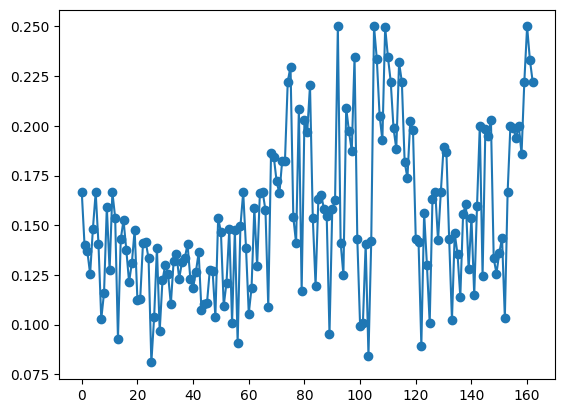

In [ ]:
norm_weight = [np.linalg.norm(w) for w in weights]
plt.plot(norm_weight, "o-")

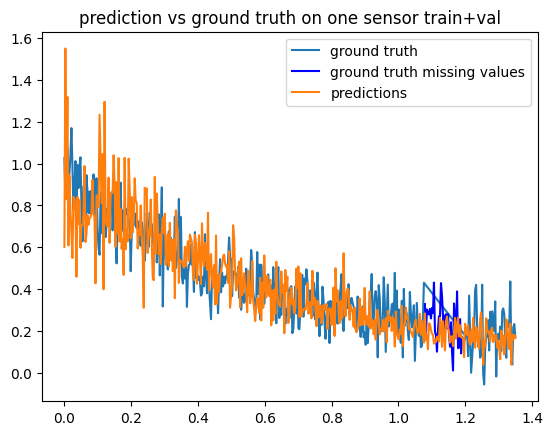

In [ ]:
sen = 4
time_train = time[:train_size+val_size]
m = torch.stack(out_data_train_val[2])
pred = torch.stack(predictions).cpu().detach()
targ = velocity_train_val[:,sen].cpu().detach().numpy()
plt.plot(time_train[m[:,sen] != -float("Inf")],targ[m[:,sen]!=-float("Inf")], label = "ground truth")
plt.plot(time_train[m[:,sen] == -float("Inf")], targ[m[:,sen]==-float("Inf")], "b", label = "ground truth missing values")
plt.plot(time_train, pred[:,sen], label = "predictions")
plt.title("prediction vs ground truth on one sensor train+val")
plt.legend()


In [ ]:
A_list_test = [a.to(device) for a in out_data_test[0]]
mask_list_test = [m.to(device) for m in out_data_test[2]]
velocity_test = data_vel[-test_size:,:].to(device)

tt_test = torch.tensor(time[-test_size:], dtype = torch.float32).to(device)
xx = torch.tensor(x_node, dtype = torch.float32).to(device)
g_test = torch.stack(torch.meshgrid(tt_test, xx)).reshape(2,-1).T.requires_grad_(True).to(device)
vel_test = out_data_test[1].to(device)


missing_test = 0
count_missing = 0
count_available = 0
available_test = 0
data_loss_test = 0

error_on_missing = []
error_on_available = []

with torch.no_grad():
    model.eval()
    predictions_test, weights_test = model.forward(A_list_test, g_test, vel_test, mask_list_test)

    for i in range(test_size):

      mask = mask_list_test[i].clone()
      mask[mask==-float("Inf")]=0

      data_loss_test += F.mse_loss(predictions_test[i],velocity_test[i,:])

      if len(torch.where(mask == 0)[0]) != 0:
        error_m = F.mse_loss(predictions_test[i][mask==0],velocity_test[i,mask==0])
        error_on_missing.append(error_m)
        missing_test  += error_m
        count_missing += 1

      elif len(torch.where(mask == 1)[0]) != 0:
        error_a = F.mse_loss(predictions_test[i][mask==1],velocity_test[i,mask==1])
        error_on_available.append(error_a)
        available_test += error_a
        count_available += 1

    missing_test = missing_test/count_missing
    available_test = available_test/count_available

    data_loss_test = data_loss_test/len(time)

In [ ]:
def IQR(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    return IQR

In [ ]:
df_results_egcn_physics = pd.DataFrame({
    "set": ["train", "test"],
    "error on NON missing data": [available_train.item(), available_test.item()],
    "error on missing data": [missing_train.item(), missing_test.item()]})
df_results_egcn_physics.set_index("set",inplace = True)

In [ ]:
df_results_egcn_physics

,error on NON missing data,error on missing data
set,,
train,0.022002,0.019753
test,0.011746,0.011677


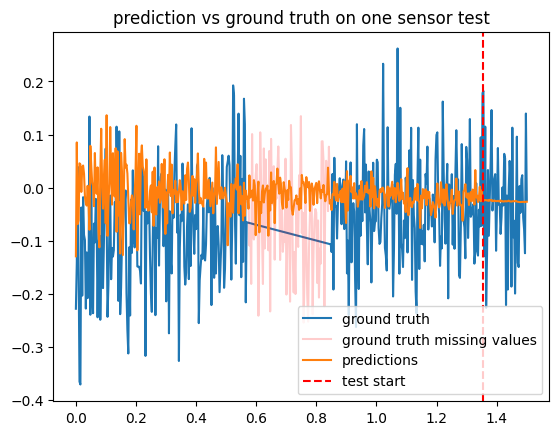

In [ ]:
sen = 28
m_test = torch.stack(out_data_test[2])
m_train_val = torch.stack(out_data_train_val[2])
m = torch.cat((m_train_val, m_test), dim = 0)
pred_test = torch.stack(predictions_test).cpu().detach()
pred_train_val = torch.stack(predictions).cpu().detach()
pred = torch.cat((pred_train_val, pred_test), dim = 0)
#targ = data_tot[:,sen,2].cpu().detach().numpy()
targ = data_vel[:,sen].cpu().detach().numpy()
plt.plot(time[m[:,sen] != -float("Inf")],targ[m[:,sen]!=-float("Inf")], label = "ground truth")
plt.plot(time[m[:,sen] == -float("Inf")], targ[m[:,sen]==-float("Inf")], "r", alpha = 0.2, label = "ground truth missing values")
plt.plot(time, pred[:,sen], label = "predictions")
plt.axvline(x=time[train_size+val_size], color='r', linestyle='--', label='test start')
plt.title("prediction vs ground truth on one sensor test")
plt.legend()

In [ ]:
def plot_3d_solution(x, t, u_pred, u_real):
    """Create multiple 3D visualizations of the solution"""
    # Create a meshgrid for plotting
    X, T = np.meshgrid(x, t)

    # Create a figure with subplots
    fig = plt.figure(figsize=(15, 7))
    axes = [fig.add_subplot(1, 2, i+1, projection='3d') for i in range(2)]

    # Plot predictions and ground truth
    for i, (ax, u) in enumerate(zip(axes, [u_pred, u_real])):
        surf = ax.plot_surface(X, T, u, cmap='viridis', edgecolor='none')
        ax.set_xlabel('x')
        ax.set_ylabel('t')
        ax.set_zlabel('u')
        ax.set_title(f'Surface Plot: {"Predictions" if i == 0 else "Ground Truth"}')

        # Add colorbar to the side of the respective subplot
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

        # Adjust view angles
        ax.view_init(elev=30, azim=45)

    plt.tight_layout()
    plt.show()


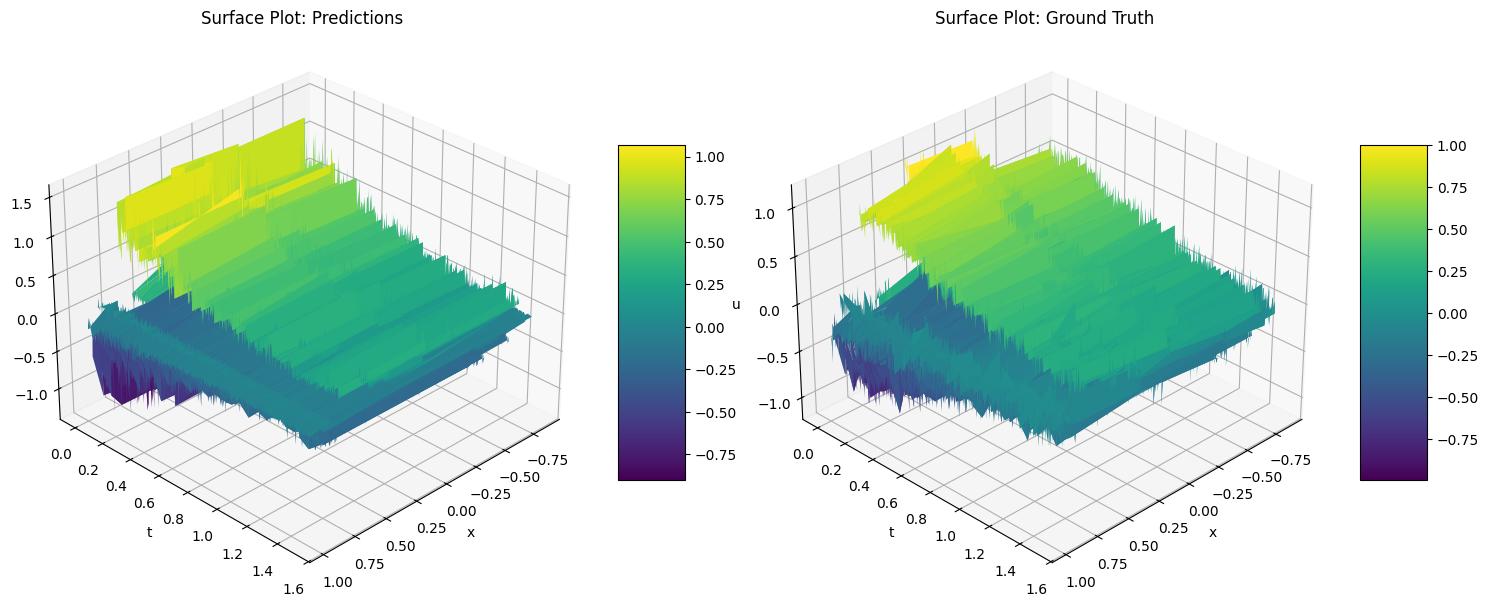

In [ ]:
plot_3d_solution(x_node, time, pred, velocity)

# many MLP

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

args_dict = Namespace({
        'feats_per_node': 4,
        'layer_1_feats': 16, # 16 is good
        # 'layer_2_feats': 32,
        # 'layer_3_feats': 16,
        }) # output dim

activation = nn.ReLU()

A_list_train_val = [a.to(device) for a in out_data_train_val[0]]
mask_list_train_val = [m.to(device) for m in out_data_train_val[2]]
velocity_train_val = data_vel[:train_size+val_size,:].to(device)
missing_nodes_train_val = [mn.to(device) for mn in out_data_train_val[3]]

tt_train_val = torch.tensor(time[:train_size+val_size], dtype = torch.float32).to(device)
xx = torch.tensor(x_node, dtype = torch.float32).to(device)
g_train_val = torch.stack(torch.meshgrid(tt_train_val, xx)).reshape(2,-1).T.requires_grad_(True).to(device)
vel_train_val = out_data_train_val[1].to(device)

#data_tot = data_tot.to(device)

n_nodes = len(x_node)

model = PredictionEGCN2(args_dict, activation, n_nodes, device, 0.5, 3, time_size = train_size+val_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
model.train()


prev_epoch_loss = torch.tensor(float("Inf"))
counter = 0

n_epochs = 30

lambda_physics = 0.3

train_data_loss = []
train_loss = []
test_loss = []
train_loss_physics = []

nu = 0.1

data_loss_list = []


for epoch in range(n_epochs):
    epoch_loss = 0
    predictions_t = []

    optimizer.zero_grad()

    #predictions, weights = model.forward(A_list_train_val, g_train_val, vel_train_val, mask_list_train_val)
    predictions, weights = model.forward(A_list_train_val, g_train_val, vel_train_val, mask_list_train_val)

    uu = torch.stack(predictions).reshape(-1)


    du_dg = torch.autograd.grad(
          inputs=g_train_val,
          outputs=uu,
          grad_outputs=torch.ones_like(uu),
          retain_graph=True,
          create_graph=True
      )[0]

    du_dt = du_dg[:,0]
    du_dx = du_dg[:,1]

    du_dxx = torch.autograd.grad(
          inputs=g_train_val,
          outputs=du_dg,
          grad_outputs=torch.ones_like(du_dg),
          retain_graph=True,
          create_graph=True
      )[0][:, 0]



    f = uu*du_dx + du_dt - nu*du_dxx

    physics_loss = F.mse_loss(f,torch.zeros_like(f))

    train_loss_physics.append(physics_loss.detach().item())


    data_loss = 0
    missing_train = 0
    count_missing = 0
    count_available = 0
    available_train = 0
    imputation_loss = 0
    data_init_loss = 0


    for i in range(train_size+val_size):

      mask = mask_list_train_val[i].clone()
      mask[mask==-float("Inf")]=0

      data_loss += F.mse_loss(predictions[i],velocity_train_val[i,:])

      if len(torch.where(mask == 1)[0]) != 0:
        available_train += F.mse_loss(predictions[i][mask==1],velocity_train_val[i,mask==1])
        count_available += 1

      if len(torch.where(mask == 0)[0]) != 0:
        missing_train += F.mse_loss(predictions[i][mask==0],velocity_train_val[i,mask==0])
        count_missing += 1

      if epoch == n_epochs-1:
        data_loss_list.append(data_loss)

    data_mean_loss = data_loss/len(time)
    missing_train = missing_train/count_missing
    available_train = available_train/count_available

    total_loss = data_mean_loss * (1-lambda_physics) + physics_loss*lambda_physics

    train_data_loss.append(data_mean_loss.detach().item())
    train_loss.append(total_loss.detach().item())

    total_loss.backward()
    optimizer.step()

    if epoch % 2 == 0:
        print(f"Epoch {epoch}")
        print(f"Data Loss: {data_mean_loss:.6f}")
        print(f"Physics Loss: {physics_loss:.6f}")
        print(f"missing train: {missing_train:.6f}")
        print(f"available train: {available_train:.6f}")


<ipython-input-199-7f6b167ebf24>:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.last_train_weights = torch.tensor(weights, device = self.GCN_init_weights.device)


Epoch 0
Data Loss: 0.145673
Physics Loss: 0.000189
missing train: 0.154514
available train: 0.162749
Epoch 2
Data Loss: 0.109640
Physics Loss: 0.001896
missing train: 0.115741
available train: 0.122298
Epoch 4
Data Loss: 0.093128
Physics Loss: 0.009404
missing train: 0.099922
available train: 0.103622
Epoch 6
Data Loss: 0.070046
Physics Loss: 0.008964
missing train: 0.071407
available train: 0.077794
Epoch 8
Data Loss: 0.059165
Physics Loss: 0.004970
missing train: 0.061114
available train: 0.066102
Epoch 10
Data Loss: 0.056810
Physics Loss: 0.004569
missing train: 0.055789
available train: 0.063457
Epoch 12
Data Loss: 0.045552
Physics Loss: 0.007238
missing train: 0.042221
available train: 0.050867
Epoch 14
Data Loss: 0.042362
Physics Loss: 0.006571
missing train: 0.043883
available train: 0.047193
Epoch 16
Data Loss: 0.037675
Physics Loss: 0.007063
missing train: 0.041798
available train: 0.041882
Epoch 18
Data Loss: 0.035131
Physics Loss: 0.007153
missing train: 0.042738
available t

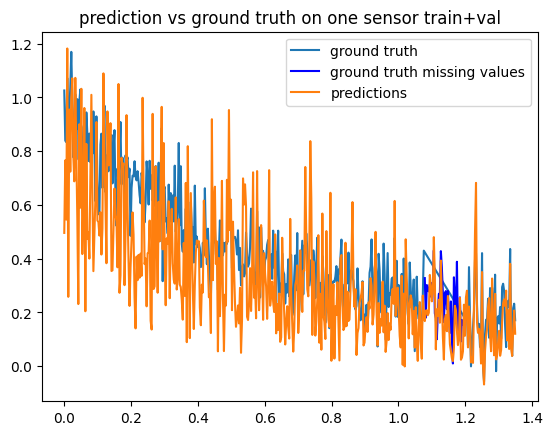

In [ ]:
sen = 4
time_train = time[:train_size+val_size]
m = torch.stack(out_data_train_val[2])
pred = torch.stack(predictions).cpu().detach()
targ = velocity_train_val[:,sen].cpu().detach().numpy()
plt.plot(time_train[m[:,sen] != -float("Inf")],targ[m[:,sen]!=-float("Inf")], label = "ground truth")
plt.plot(time_train[m[:,sen] == -float("Inf")], targ[m[:,sen]==-float("Inf")], "b", label = "ground truth missing values")
plt.plot(time_train, pred[:,sen], label = "predictions")
plt.title("prediction vs ground truth on one sensor train+val")
plt.legend()


In [ ]:
A_list_test = [a.to(device) for a in out_data_test[0]]
mask_list_test = [m.to(device) for m in out_data_test[2]]
velocity_test = data_vel[-test_size:,:].to(device)

tt_test = torch.tensor(time[-test_size:], dtype = torch.float32).to(device)
xx = torch.tensor(x_node, dtype = torch.float32).to(device)
g_test = torch.stack(torch.meshgrid(tt_test, xx)).reshape(2,-1).T.requires_grad_(True).to(device)
vel_test = out_data_test[1].to(device)


missing_test = 0
count_missing = 0
count_available = 0
available_test = 0
data_loss_test = 0

error_on_missing = []
error_on_available = []

with torch.no_grad():
    model.eval()
    predictions_test, weights_test = model.forward(A_list_test, g_test, vel_test, mask_list_test)

    for i in range(test_size):

      mask = mask_list_test[i].clone()
      mask[mask==-float("Inf")]=0

      data_loss_test += F.mse_loss(predictions_test[i],velocity_test[i,:])

      if len(torch.where(mask == 0)[0]) != 0:
        error_m = F.mse_loss(predictions_test[i][mask==0],velocity_test[i,mask==0])
        error_on_missing.append(error_m)
        missing_test  += error_m
        count_missing += 1

      elif len(torch.where(mask == 1)[0]) != 0:
        error_a = F.mse_loss(predictions_test[i][mask==1],velocity_test[i,mask==1])
        error_on_available.append(error_a)
        available_test += error_a
        count_available += 1

    missing_test = missing_test/count_missing
    available_test = available_test/count_available

    data_loss_test = data_loss_test/len(time)

In [ ]:
df_results_egcn_physics = pd.DataFrame({
    "set": ["train", "test"],
    "error on NON missing data": [available_train.item(), available_test.item()],
    "error on missing data": [missing_train.item(), missing_test.item()]})
df_results_egcn_physics.set_index("set",inplace = True)

In [ ]:
df_results_egcn_physics

,error on NON missing data,error on missing data
set,,
train,0.035136,0.033626
test,0.034200,0.090740


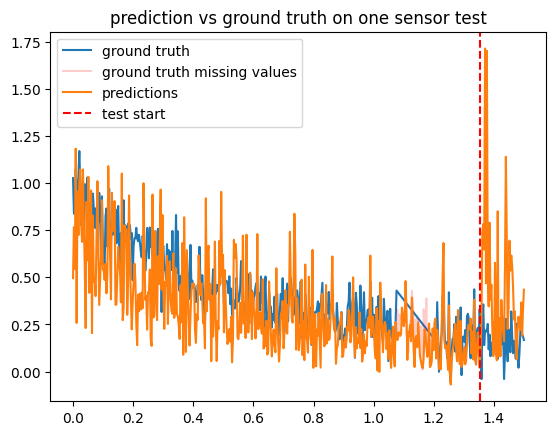

In [ ]:
sen = 4
m_test = torch.stack(out_data_test[2])
m_train_val = torch.stack(out_data_train_val[2])
m = torch.cat((m_train_val, m_test), dim = 0)
pred_test = torch.stack(predictions_test).cpu().detach()
pred_train_val = torch.stack(predictions).cpu().detach()
pred = torch.cat((pred_train_val, pred_test), dim = 0)
#targ = data_tot[:,sen,2].cpu().detach().numpy()
targ = data_vel[:,sen].cpu().detach().numpy()
plt.plot(time[m[:,sen] != -float("Inf")],targ[m[:,sen]!=-float("Inf")], label = "ground truth")
plt.plot(time[m[:,sen] == -float("Inf")], targ[m[:,sen]==-float("Inf")], "r", alpha = 0.2, label = "ground truth missing values")
plt.plot(time, pred[:,sen], label = "predictions")
plt.axvline(x=time[train_size+val_size], color='r', linestyle='--', label='test start')
plt.title("prediction vs ground truth on one sensor test")
plt.legend()